## Show traces

In [1]:
import numpy as np
import pandas as pd

import ahrs

import matplotlib.pyplot as plt

from tqdm import tqdm

## Load data

In [2]:
# Load Arduino-based IMU dump
imu_df = pd.read_csv("../data/set1_imu.csv")
imu_df

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,43371514769600,730406,-3.9900,-3.3763,7.1581,0.4435,0.2822,0.0770,20.25
1,43371526109300,730418,-3.9171,-2.0626,6.5539,0.4300,0.1955,0.0586,20.21
2,43371537892800,730429,-4.3848,-2.0913,6.5695,-0.1943,-0.0586,-0.1319,20.25
3,43371549019900,730441,-4.5607,-2.6261,7.0074,-0.6060,-0.2944,-0.2957,20.25
4,43371560073300,730452,-4.5691,-3.5462,7.8341,-0.8821,-0.4826,-0.4398,20.21
...,...,...,...,...,...,...,...,...,...
75962,44229629181000,1588504,-7.7515,3.9529,5.0572,0.0330,0.0415,-0.0476,23.49
75963,44229640340200,1588515,-7.7815,3.9338,5.0680,0.0183,0.0293,-0.0440,23.52
75964,44229652049200,1588527,-7.7922,3.8740,5.0943,0.0061,0.0134,-0.0464,23.52
75965,44229663120200,1588538,-7.7982,3.7507,5.1338,-0.0037,-0.0012,-0.0501,23.48


In [3]:
# Load Wacom tablet dump
tablet_df = pd.read_csv("../data/set1_tab.csv", encoding="utf_16_le")
tablet_df

,host_timestamp,x,y,z,in_range,touch,pressure,reset
0,43375067069000,-125.000000,727.000000,0,0,0,0,0
1,43375085835600,-125.000000,727.000000,0,0,0,0,0
2,43375103211700,-125.000000,727.000000,0,0,0,0,0
3,43375119624300,-125.000000,727.000000,0,0,0,0,0
4,43375136587100,-125.000000,727.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...
57262,44224171305000,421.307164,117.212863,0,0,0,0,0
57263,44224187636300,421.307164,117.212863,0,0,0,0,0
57264,44224204691800,421.307164,117.212863,0,0,0,0,0
57265,44224219941300,421.307164,117.212863,0,0,0,0,0


## Timestamp innaccuracies

In [4]:
# Compute steps, using both clocks
df = imu_df[["host_timestamp", "arduino_timestamp"]].diff().dropna().astype(int)
df

,host_timestamp,arduino_timestamp
1,11339700,12
2,11783500,11
3,11127100,12
4,11053400,11
5,11744400,12
...,...,...
75962,10917200,11
75963,11159200,11
75964,11709000,12
75965,11071000,11


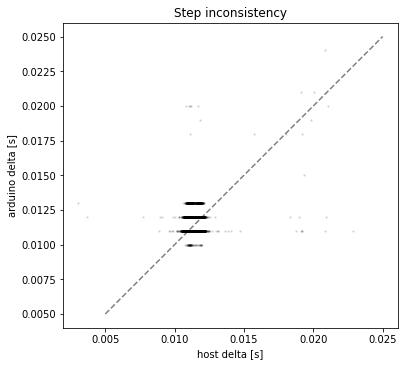

In [5]:
# Due to transmission and processing delay, the `host_timestamp` is not accurate
_, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    df["host_timestamp"] * 1e-9,
    df["arduino_timestamp"] * 1e-3,
    c="k",
    s=2,
    alpha=0.1,
)
ax.plot([0.005, 0.025], [0.005, 0.025], c="gray", ls="--", zorder=-1)
ax.set_aspect("equal")
ax.set_xlabel("host delta [s]")
ax.set_ylabel("arduino delta [s]")
ax.set_title("Step inconsistency")
plt.show()

In [6]:
# Most common effective time steps
df["arduino_timestamp"].value_counts()

11    54108
12    21146
13      644
10       52
20        6
18        4
21        2
19        2
24        1
15        1
Name: arduino_timestamp, dtype: int64

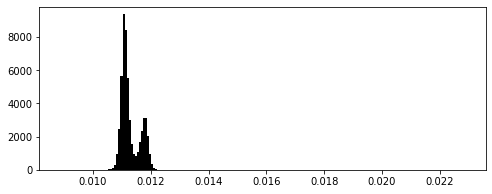

In [7]:
# Show distribution
_, ax = plt.subplots(figsize=(8, 3))
imu_df["arduino_timestamp"].diff()
values = df.loc[df["arduino_timestamp"] == 11, "host_timestamp"]
ax.hist(values * 1e-9, bins=200, fc="k")
plt.show()

## Resample

In [8]:
# Tablet is roughly sampled at 60Hz
1.0 / (tablet_df["host_timestamp"].diff().median() * 1e-9)

62.58292237214309

In [9]:
# IMU is roughly sampled at 90Hz
1.0 / (imu_df["host_timestamp"].diff().median() * 1e-9)

89.58807403558438

In [10]:
# Intersection duration
t_left, t_right = tablet_df["host_timestamp"].iloc[[0, -1]]
i_left, i_right = imu_df["host_timestamp"].iloc[[0, -1]]
left = max(t_left, i_left)
right = min(t_right, i_right)
(right - left) * 1e-9

849.1693686000001

In [11]:
# Keep only the intersection
df = imu_df[(imu_df["host_timestamp"] >= left) & (imu_df["host_timestamp"] <= right)].copy()

In [12]:
# Interpolate continuous variables
# Note: booleans that are true/false over a period of time are considered as continuous
for column in ["x", "y", "z", "in_range", "touch", "pressure"]:
    df[column] = np.interp(df["host_timestamp"], tablet_df["host_timestamp"], tablet_df[column])

In [13]:
# For reset, assign to closest timestamp
mask = tablet_df["reset"] != 0
indices = np.searchsorted(df["host_timestamp"], tablet_df.loc[mask, "host_timestamp"])
df["reset"] = 0
df.loc[df.index[indices], "reset"] = tablet_df.loc[mask, "reset"].values

In [14]:
# Show extract
df

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature,x,y,z,in_range,touch,pressure,reset
315,43375070723400,733964,-6.2584,4.5129,6.0251,-0.6671,0.0574,0.0391,20.29,-125.000000,727.000000,0.0,0.0,0.0,0.0,0
316,43375082694400,733975,-6.1543,4.7019,6.3446,-0.3641,0.1210,0.1381,20.29,-125.000000,727.000000,0.0,0.0,0.0,0.0,0
317,43375093727500,733986,-6.4271,4.7210,5.9474,-0.2016,0.2407,0.2456,20.29,-125.000000,727.000000,0.0,0.0,0.0,0.0,0
318,43375104950600,733998,-6.1352,4.9699,5.7595,0.1881,0.3176,0.4679,20.29,-125.000000,727.000000,0.0,0.0,0.0,0.0,0
319,43375116785300,734009,-6.0455,5.4987,5.6435,0.4166,0.2920,0.5107,20.25,-125.000000,727.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75480,44224181971000,1583056,-7.9669,3.7890,4.9484,0.0403,-0.0415,-0.0367,23.53,421.307164,117.212863,0.0,0.0,0.0,0.0,0
75481,44224193055700,1583068,-7.9693,3.7807,4.9268,0.0257,-0.0660,-0.0367,23.53,421.307164,117.212863,0.0,0.0,0.0,0.0,0
75482,44224204147000,1583079,-7.9083,3.8058,4.9795,0.0171,-0.0965,-0.0367,23.50,421.307164,117.212863,0.0,0.0,0.0,0.0,0
75483,44224215046800,1583091,-7.8556,3.7831,5.0919,0.0086,-0.1112,-0.0342,23.50,421.307164,117.212863,0.0,0.0,0.0,0.0,0


## Synchronization

In [15]:
# Start at zero, for convenience
df["timestamp"] = (df["host_timestamp"] - left) * 1e-9

In [16]:
# Compute acceleration norm
df["a"] = np.sqrt(df["ax"] ** 2 + df["ay"] ** 2 + df["az"] ** 2)

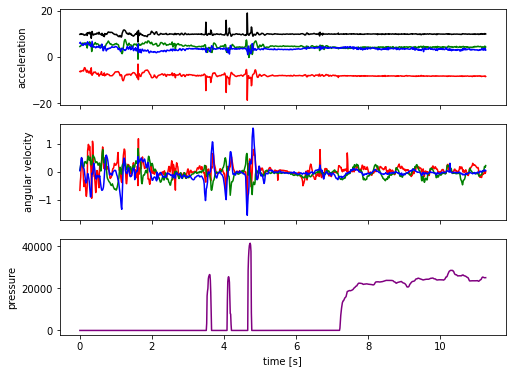

In [17]:
# Show acceleration, angular velocity, and tip pressure
_, axes = plt.subplots(3, sharex=True, figsize=(8, 6))
axes[0].plot(df["timestamp"].iloc[:1000], df["ax"].iloc[:1000], c="r")
axes[0].plot(df["timestamp"].iloc[:1000], df["ay"].iloc[:1000], c="g")
axes[0].plot(df["timestamp"].iloc[:1000], df["az"].iloc[:1000], c="b")
axes[0].plot(df["timestamp"].iloc[:1000], df["a"].iloc[:1000], c="k")
axes[0].set_ylabel("acceleration")
axes[1].plot(df["timestamp"].iloc[:1000], df["gx"].iloc[:1000], c="r")
axes[1].plot(df["timestamp"].iloc[:1000], df["gy"].iloc[:1000], c="g")
axes[1].plot(df["timestamp"].iloc[:1000], df["gz"].iloc[:1000], c="b")
axes[1].set_ylabel("angular velocity")
axes[2].plot(df["timestamp"].iloc[:1000], df["pressure"].iloc[:1000], c="purple")
axes[2].set_ylabel("pressure")
axes[-1].set_xlabel("time [s]")
plt.show()

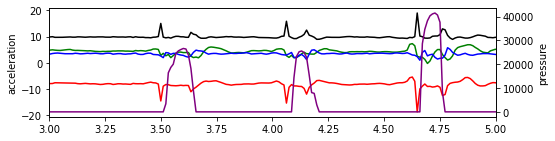

In [18]:
# Focus on acceleration and pressure, when the pen was tapped 3 times
_, ax = plt.subplots(figsize=(8, 2))
ax.plot(df["timestamp"].iloc[:500], df["ax"].iloc[:500], c="r")
ax.plot(df["timestamp"].iloc[:500], df["ay"].iloc[:500], c="g")
ax.plot(df["timestamp"].iloc[:500], df["az"].iloc[:500], c="b")
ax.plot(df["timestamp"].iloc[:500], df["a"].iloc[:500], c="k")
ax.set_ylabel("acceleration")
ax2 = ax.twinx()
ax2.plot(df["timestamp"].iloc[:500], df["pressure"].iloc[:500], c="purple")
ax2.set_ylabel("pressure")
ax.set_xlim(3.0, 5.0)
plt.show()

In [19]:
# TODO try to align this?

## Show traces

In [20]:
# How many segments were reported?
boundaries, = np.where(df["reset"] == 1)
len(boundaries)

51

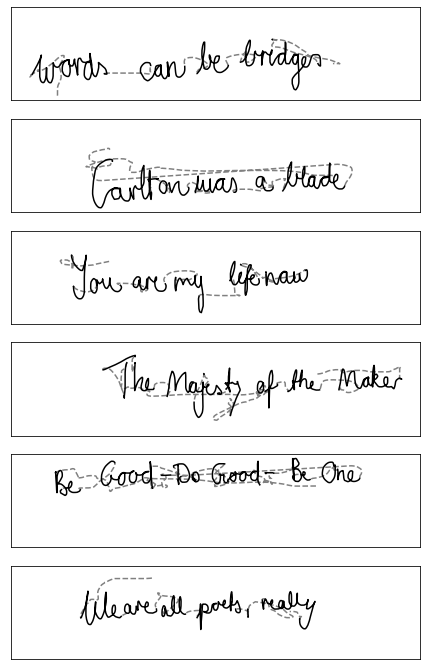

In [21]:
# Show some of them
indices = [0, 1, 2, 3, 4, 5]
_, axes = plt.subplots(len(indices), sharex=True, sharey=True, figsize=(8, 2 * len(indices)))
for index in indices:
    chunk_df = df.iloc[boundaries[index]:boundaries[index+1]]
    touch = chunk_df["touch"] > 0
    axes[index].plot(chunk_df["x"].where(touch), chunk_df["y"].where(touch), c="k")
    axes[index].plot(chunk_df["x"].where(~touch), chunk_df["y"].where(~touch), c="gray", ls="--", zorder=-1)
    axes[index].set_aspect("equal")
    axes[index].set_xticks([])
    axes[index].set_yticks([])
plt.show()

## Show orientation

In [22]:
# Get IMU data as arrays
T = df["timestamp"].values
A = df[["ax", "ay", "az"]].values
G = df[["gx", "gy", "gz"]].values

In [23]:
# Apply Madgwick filter
madgwick = ahrs.filters.Madgwick()
Q = np.zeros((len(T), 4))
Q[0] = ahrs.common.orientation.acc2q(A[0])
for i in tqdm(range(1, len(T))):
    madgwick.Dt = T[i] - T[i - 1]
    Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])

100%|█████████████████████████████████████████████████████████████████████████| 75169/75169 [00:04<00:00, 15734.48it/s]


In [24]:
# https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Quaternion-derived_rotation_matrix
def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

In [25]:
# Get rotation matrix associated to quaternions (body to navigation)
R = rotation_matrix(Q)

In [26]:
# Get inverse matrix (navigation to body)
# Note: matrices are orthogonal, so transpose is equivalent to inversion
R_inv = R.transpose(0, 2, 1)

In [27]:
# X-axis is pointing alongside the pen, toward the tip
forward = R[:, :, 0]

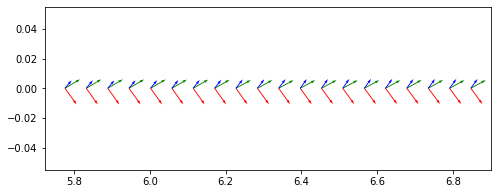

In [28]:
i = 0
ex = np.array([1.0, 0.0, 0.0])
ey = np.array([0.0, 0.0, 1.0])
indices = np.arange(boundaries[i], boundaries[i] + 100, 5)
_, ax = plt.subplots(figsize=(8, 3))
for j, c in enumerate("rgb"):
    ax.quiver(
        T[indices],
        np.zeros(len(indices)),
        R[indices, :, j] @ ex,
        R[indices, :, j] @ ey,
        color=c,
        scale_units="dots",
        scale=0.05,
        width=0.002,
    )
plt.show()

In [29]:
# TODO finish this